This notebook performs a series of simple operations aiming to filter a massive number of stocks based on specific criteria and utilizing finance-related Python packages. 

First, I source the tickers of all currently listed American stocks. Next, I perform two filtering operations based on two of their fundamental valuation measures (PeRatio and PegRatio) to narrow down the number of stocks to 100. 

Then I perform a fast Monter Carlo simulation on each stock's price, selecting the ones that have the highest positive difference between their latest closing price and the mean of the estimated closing prices from the MC simulations at a selected time point in the future.
Finally, a final Monte Carlo simulation for the entire portfolio is performed. 

The Notebook takes between 30 and 50 minutes to run as is, depending on hardware. Not running the final cell (visualization of simulations) reduces the running time by about 40%. 

Reducing the number of Monter Carlo scenarios or the time horizon of simulations in certain cells can also significantly reduce time of execution, at the cost of accuracy. 

Author: Konstantinos Tassopoulos

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
from yahooquery import Ticker
from dateutil.relativedelta import relativedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import warnings
sns.set_theme()

## Sourcing Tickers

Below I create one list with all the tickers from a .json file which can be found [here](https://github.com/rreichel3/US-Stock-Symbols). Make sure to clone the repository.

In [2]:
nasdaq_stocks = pd.read_json("nasdaq_full_tickers.json")
nyse_stocks = pd.read_json("nyse_full_tickers.json")
amex_stocks = pd.read_json("amex_full_tickers.json")

All the available information about the stocks is downloaded instead of just the tickers so that we can inspect the details of the companies of the selected stocks later on.

In [3]:
nasdaq_stocks

,symbol,name,lastsale,netchange,pctchange,volume,marketCap,country,ipoyear,industry,sector,url
0,AACG,ATA Creativity Global American Depositary Shares,$0.90,-0.0023,-0.255%,4907,28800117.00,China,2008,Other Consumer Services,Real Estate,/market-activity/stocks/aacg
1,AACI,Armada Acquisition Corp. I Common Stock,$11.41,-0.5697,-4.756%,47344,0.00,United States,2021,Blank Checks,Finance,/market-activity/stocks/aaci
2,AACIU,Armada Acquisition Corp. I Unit,$11.17,0.1600,1.453%,147,0.00,United States,2021,Blank Checks,Finance,/market-activity/stocks/aaciu
3,AACIW,Armada Acquisition Corp. I Warrant,$0.16,0.0030,1.911%,22889,0.00,United States,2021,Blank Checks,Finance,/market-activity/stocks/aaciw
4,AADI,Aadi Bioscience Inc. Common Stock,$1.78,-0.1000,-5.319%,200204,43706485.00,United States,,Biotechnology: Pharmaceutical Preparations,Health Care,/market-activity/stocks/aadi
...,...,...,...,...,...,...,...,...,...,...,...,...
3989,ZURAW,Zura Bio Limited Warrants,$0.66,0.0000,0.00%,7,28771827.00,Cayman Islands,,Biotechnology: Biological Products (No Diagnos...,Health Care,/market-activity/stocks/zuraw
3990,ZVRA,Zevra Therapeutics Inc. Common Stock,$4.82,-0.2100,-4.175%,250744,209314217.00,United States,,Biotechnology: Pharmaceutical Preparations,Health Care,/market-activity/stocks/zvra
3991,ZVSA,ZyVersa Therapeutics Inc. Common Stock,$5.37,0.0900,1.705%,61455,4078440.00,United States,2022,Biotechnology: Pharmaceutical Preparations,Health Care,/market-activity/stocks/zvsa
3992,ZYME,Zymeworks Inc. Common Stock,$8.81,-0.4200,-4.55%,985858,622910081.00,United States,,Biotechnology: Pharmaceutical Preparations,Health Care,/market-activity/stocks/zyme


In [4]:
# Concatenate all tickers 
all_stocks = pd.concat([nasdaq_stocks, nyse_stocks, amex_stocks])

In [5]:
# Check columns
all_stocks.columns

Index(['symbol', 'name', 'lastsale', 'netchange', 'pctchange', 'volume',
       'marketCap', 'country', 'ipoyear', 'industry', 'sector', 'url'],
      dtype='object')

In [6]:
# Drop unnecessary columns
all_symbols = all_stocks.drop(
    [
        'lastsale', 'netchange', 'pctchange' , 'marketCap',
        'country', 'ipoyear', 'volume', 'sector', 'industry', 'url'
    ], 
    axis=1
)

In [7]:
# Drop duplicates 
all_symbols.drop_duplicates(inplace=True)

In [8]:
# Check for null values and drop rows if there are any, then return total number of tickers
if all_symbols.isnull().values.any() is True:
    all_symbols.dropna(inplace=True)
    print(f"There are {len(all_symbols)} tickers to be filtered.")
else:
    print(f"There are {len(all_symbols)} tickers to be filtered.")

There are 7103 tickers to be filtered.


In [9]:
# Create a list of tickers, and then a list with a single string needed for yahooquery
symbols = all_symbols["symbol"].to_list()
tickers_to_check = ' '.join(symbols)

## Selection of stocks

In [10]:
# Initialize yahooquery Ticker class to get valuation measures for all tickers
# This and the following cell take about 10-15 mins to run together
tickers_for_valuation = Ticker(tickers_to_check)

In [11]:
# Get Pe and Peg rations for each ticker, you can also select any other 
# available valuation measure from https://yahooquery.dpguthrie.com/guide/ticker/financials/
valuation_data = tickers_for_valuation.valuation_measures[["PeRatio", "PegRatio"]]
valuation_data.reset_index(inplace=True)

In [12]:
valuation_data

,symbol,PeRatio,PegRatio
0,A,30.502252,2.6499
1,A,26.821586,2.3761
2,A,27.060209,2.4204
3,A,31.050119,2.4990
4,A,NaN,NaN
...,...,...,...
42329,ZYXI,21.311111,NaN
42330,ZYXI,17.777778,NaN
42331,ZYXI,25.325581,NaN
42332,ZYXI,45.814815,NaN


In [13]:
# Optional cell, saves time when the Notebook needs to be rerun
# valuation_data.to_csv("valuation_measures.csv")

In [14]:
# Optional cell, saves time when the Notebook needs to be rerun
# valuation_data = pd.read_csv("valuation_measures.csv")

In [15]:
# Optional cell, saves time when the Notebook needs to be rerun
# valuation_data.drop("Unnamed: 0", axis=1, inplace=True)

In [16]:
# Keep only latest ratios instead of all quarters by dropping duplicate symbols, 
# then clean data by removing nulls (either because of no availability 
# or because or Yahoo errors) and reset index 
most_recent_data = valuation_data.drop_duplicates(['symbol'], keep="last") 
cleaned_valuation_data = most_recent_data.dropna()
cleaned_valuation_data.reset_index(inplace=True, drop=True)

In [17]:
cleaned_valuation_data

,symbol,PeRatio,PegRatio
0,A,36.916268,2.9533
1,AAL,20.830986,0.3054
2,AAP,147.900000,1.4048
3,AAPL,29.524106,2.2512
4,AB,14.033058,1.4138
...,...,...,...
795,ZBRA,63.338614,0.9438
796,ZM,30.898551,4.9299
797,ZTO,16.529534,1.8395
798,ZTS,33.470135,2.9859


In [18]:
# Keep only stocks with a Peg ratio equal to or under 1.2
peg_ratio_checked = cleaned_valuation_data.loc[cleaned_valuation_data["PegRatio"] <= 1.2]

In [19]:
# Sort stocks from low to high PeRatio
pe_checked = peg_ratio_checked.sort_values(by="PeRatio", axis=0, ascending=True)

In [20]:
# Select 100 stock with the lowest PeRatio and a PegRatio equal to or under 1.2
final_selection = pe_checked[0:100]

In [21]:
final_selection

,symbol,PeRatio,PegRatio
725,UBS,3.470520,0.4932
675,SURG,3.561404,1.0410
181,CVGI,4.123077,0.3408
393,JOB,5.266667,1.0533
172,CSIQ,5.595819,0.2757
...,...,...,...
348,HST,18.382353,0.9065
214,DOX,18.410314,1.1609
95,BKR,18.446927,0.9383
533,ODP,18.538813,0.4093


In [22]:
# Create list with tickers of the selected stocks
final_selection_symbols = final_selection["symbol"].to_list()

Now we've got 100 stocks with the lowest PeRatios and low enough Peg ratios. Next, historical price data about the stocks will be downloaded from Yahoo. Monte Carlo simulations will then be performed based on the stock's past price action, and the 10 best stocks will be selected based on that calculation.

In [23]:
# Ignore yfinance warning of issue: https://github.com/ranaroussi/yfinance/issues/1837
warnings.filterwarnings(
    "ignore", 
    message="The 'unit' keyword in TimedeltaIndex construction is\
    deprecated and will be removed in a future version. \
    Use pd.to_timedelta instead.", 
    category=FutureWarning, 
    module="yfinance.utils"
)


# Create function that collects stock historical prices and only keeps closing prices
def get_stock_price(stocks, start, end):
    stock_data = yf.download(stocks, start, end)
    close_prices = stock_data["Close"]
    return close_prices

In [24]:
# Download historical prices for the 100 best stocks, check for na and drop them if they exist
hundred_best_data = get_stock_price(final_selection_symbols, "2023-01-01", dt.datetime.now())
if hundred_best_data.isnull().values.any() is True:
    hundred_best_data.dropna()
    hundred_best_tickers = hundred_best_data.columns.tolist()
else:
    hundred_best_tickers = hundred_best_data.columns.tolist()

[*********************100%%**********************]  100 of 100 completed


In [25]:
# random_test = hundred_best_data.iloc[:, 0:10]
# random_test.to_csv("Exhibit_1.csv")

In [26]:
# The function performs a Monte Carlo simulation of 10000 iterations based on selected dates
# Parts of the code taken and adapted from Matteo Bottacini, original code available in 
# https://github.com/bottama/stochastic-asset-pricing-in-continuous-time
def stocks_selection_simulation(stock, startdate, enddate, pred_end_date):
    
    # Download historical stock prices based on start and end date
    stock_checked = get_stock_price(stock, startdate, enddate)
    
    end_date = stock_checked.index[-1]
    pred_end_date = pred_end_date
    # Scenario size can be changed according to machine's specs: generally the higher, the better
    scen_size = 10000

    # Initial stock price
    So = stock_checked.iloc[-1]

    # Daily time increment  
    time_increment = 1

    # Definition of US business day
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    # Definition of weekday
    n_of_wkdays = len(pd.date_range(start=end_date, end=pred_end_date,freq=us_bd))

    # Time steps of prediction
    time_points = n_of_wkdays/time_increment
    t = np.arange(1, int(time_points) + 1)

    # Mean return of the stock prices within the historical date range selected 
    daily_returns = ((stock_checked/stock_checked.shift(1)) - 1)[1:]
    mu = np.mean(daily_returns)

    # Standard deviation of returns
    sigma = np.std(daily_returns)

    # Dictionary with random normal distribution
    b = {str(scen): np.random.normal(0, 1, int(time_points)) for scen in range(1, scen_size + 1)}

    # The Brownian path determines how the stock prices fluctuate from
    # initial stock price to some other time point t.
    Brownian_path = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


    # GBM drift
    drift = (mu - 0.5 * sigma ** 2) * t

    # GBM Diffusion
    diffusion = {str(scen): sigma * Brownian_path[str(scen)] for scen in range(1, scen_size + 1)}

    # GBM model
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) 

    # Array containing mean predictions of GBM model
    S_mean = [S[:, i].mean() for i in range(0, int(time_points))]

    # Difference between last time point of mean predictions and current price
    mean_price_difference = S_mean[-1] - So

    return  mean_price_difference

In [27]:
# Function that takes list of tickers, applies Monte Carlo sims, and returns
# a dataframe with the stocks sorted 
def best_stocks(list_of_tickers, startdate, enddate, pred_end_date):
    
    dictionary = {}
    for ticker in list_of_tickers:
        dictionary[ticker] = stocks_selection_simulation(ticker, startdate, enddate, pred_end_date)

    results = pd.DataFrame.from_dict(dictionary, orient="index", columns=["Price Difference"]) # "Lower Prediction Interval"
    results = results.sort_values(by="Price Difference", axis=0, ascending=False) # by="Lower Prediction Interval"
    return results      

Use %%capture to supress output which shows stocks loading 1 by 1:

In [28]:
%%capture  
stocks_ranked = best_stocks(hundred_best_tickers, "2023-01-01",  dt.datetime.now(), dt.datetime.now()+relativedelta(years=1)) # ~30 seconds

In [29]:
# stocks_ranked.to_csv("Stocks_ranked.csv")

In [30]:
# stocks_ranked = pd.read_csv("Stocks_ranked.csv")
# stocks_ranked.set_index("Unnamed: 0", inplace=True)

In [31]:
stocks_ranked.head(10)

,Price Difference
GCT,210.633583
RCL,188.855232
TOL,143.429374
AMP,137.619790
PHM,127.261445
FDX,93.049513
ABG,91.199403
LAD,90.178726
DHI,78.277900
MPTI,75.575410


In [32]:
stocks_ranked.tail(10)

,Price Difference
SEE,-4.676381
DOX,-5.105894
JACK,-5.374803
HE,-5.534046
PII,-7.241383
WNS,-10.837061
INCY,-10.857033
AGCO,-11.588632
CNXC,-23.355164
CHTR,-25.040309


### Selection and Inspection of 10 best Stocks from 100

In [33]:
stocks_ranked_list = list(stocks_ranked.index)
selected_stocks = stocks_ranked_list[0:10]
selected_stocks

['GCT', 'RCL', 'TOL', 'AMP', 'PHM', 'FDX', 'ABG', 'LAD', 'DHI', 'MPTI']

In the following cells, we use the object with the companies' data we downloaded at the beginning of the notebook to create a Dataframe with all the information about the selected companies. This will allow us to check the industry/sector of each company in case we need to diversify our portfolio even more. 

In [34]:
sector_check_filter = all_stocks['symbol'].isin(selected_stocks)

In [35]:
sector_check = all_stocks[sector_check_filter].drop_duplicates()
sector_check

,symbol,name,lastsale,netchange,pctchange,volume,marketCap,country,ipoyear,industry,sector,url
1458,GCT,GigaCloud Technology Inc Class A Ordinary Shares,$37.35,-2.37,-5.967%,2549387,1523783786.00,Hong Kong,2022,Catalog/Specialty Distribution,Consumer Discretionary,/market-activity/stocks/gct
9,ABG,Asbury Automotive Group Inc Common Stock,$224.82,-1.46,-0.645%,137941,4535122322.00,United States,2002,Retail-Auto Dealers and Gas Stations,Consumer Discretionary,/market-activity/stocks/abg
140,AMP,Ameriprise Financial Inc. Common Stock,$433.55,3.52,0.819%,329956,43062320367.00,United States,,Investment Managers,Finance,/market-activity/stocks/amp
745,DHI,D.R. Horton Inc. Common Stock,$149.97,0.47,0.314%,2085601,49386957833.00,United States,,Homebuilding,Consumer Discretionary,/market-activity/stocks/dhi
992,FDX,FedEx Corporation Common Stock,$265.73,3.67,1.40%,1091243,65391037698.00,United States,,Air Freight/Delivery Services,Consumer Discretionary,/market-activity/stocks/fdx
1484,LAD,Lithia Motors Inc. Common Stock,$264.26,0.20,0.076%,168526,7242437990.00,United States,,Retail-Auto Dealers and Gas Stations,Consumer Discretionary,/market-activity/stocks/lad
1989,PHM,PulteGroup Inc. Common Stock,$117.68,0.69,0.59%,1614199,24753059858.00,United States,,Homebuilding,Consumer Discretionary,/market-activity/stocks/phm
2123,RCL,Royal Caribbean Cruises Ltd. Common Stock,$141.04,-0.70,-0.494%,1154067,36296530604.00,United States,1993,Marine Transportation,Consumer Discretionary,/market-activity/stocks/rcl
2501,TOL,Toll Brothers Inc. Common Stock,$127.02,0.54,0.427%,608756,13231673400.00,United States,,Homebuilding,Consumer Discretionary,/market-activity/stocks/tol
175,MPTI,M-tron Industries Inc. Common Stock,$28.65,0.60,2.139%,33443,80106288.00,,2022,Industrial Machinery/Components,Technology,/market-activity/stocks/mpti


## Monte Carlo Portfolio Simulations 

This part of the notebook is an adaptation of the code presented in QuantPy channel's YouTube video: ["Monte Carlo Simulation of a Stock Portfolio with Python"](https://www.youtube.com/watch?v=6-dhdMDiYWQ). More information can be found in that video, its description, and QuantPy's [website](https://quantpy.com.au/).

In [36]:
# Function which downloads stock historical prices and
# returns percentage changes and covariance matrix
def calc_stock_data(stocks, start, end):
    stock_data = yf.download(stocks, start, end)
    close_prices = stock_data["Close"]
    returns = close_prices.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

In [37]:
# Select end date and starting date for previous function
# Larger periods heavily affect the algorithm because of varying levels of volatility
endDate = dt.datetime.now()
startDate = "2023-01-01"

In [38]:
mean_returns, cov_matrix  = calc_stock_data(selected_stocks, startDate, endDate)

[*********************100%%**********************]  10 of 10 completed


### Ensure weights follow actual portfolio allocation.

In [39]:
# Manual selection of weights
weights = np.array([0.1]*10)

In [40]:
# Number of simulations, timeframe of future prediction and initial portfolio
mc_sims = 1000000
timeframe = 365
initial_portfolio = 10000

In [41]:
# Monte Carlo
mean_matrix = np.full(shape=(timeframe, len(weights)), fill_value=mean_returns)

portfolio_sims = np.full(shape=(timeframe, mc_sims), fill_value=0.0)

for m in range(0, mc_sims):
    Z = np.random.normal(size=(timeframe, len(weights)))
    L = np.linalg.cholesky(cov_matrix)
    daily_returns = mean_matrix.T + np.inner(L, Z)
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio

In [42]:
# Statistics definitions
mean = np.round(np.mean(portfolio_sims), 2)
twenty_five_percentile = np.round(np.percentile(portfolio_sims, 25), 2)
seventy_five_percentile = np.round(np.percentile(portfolio_sims, 75), 2)
sims_under_inPortf_perc = np.round(np.sum(portfolio_sims < initial_portfolio)/(mc_sims*timeframe), 2)*100
sims_over_inPortf_perc = np.round(np.sum(portfolio_sims > initial_portfolio)/(mc_sims*timeframe), 2)*100
sims_over_10_perc = np.round(
    np.sum(portfolio_sims > initial_portfolio+10*initial_portfolio/100)/(mc_sims*timeframe), 2
)*100
min_sim = np.round((portfolio_sims.min()), 2)
max_sim = np.round((portfolio_sims.max()), 2)

# Dataframe from dictionary of descriptive statistics
descr_dict = {
    "Mean Returns": mean,
    "25th percentile": twenty_five_percentile,
    "75th percentile": seventy_five_percentile,
    "Max Simulation Result": max_sim,
    "Min Simulation Result": min_sim,
    "Percentage of Simulations Resulting in Profit": f"{sims_over_inPortf_perc}%",
    "Percentage of Simulations Resulting in Loss": f"{sims_under_inPortf_perc}%",
    "Percentage of Simulations with more than 10% profit": f"{sims_over_10_perc}%"
}


results = pd.DataFrame.from_dict(data=descr_dict, orient="index", columns=[""])

results

,
Mean Returns,17510.63
25th percentile,12268.5
75th percentile,20991.31
Max Simulation Result,113064.59
Min Simulation Result,5441.38
Percentage of Simulations Resulting in Profit,96.0%
Percentage of Simulations Resulting in Loss,4.0%
Percentage of Simulations with more than 10% profit,86.0%


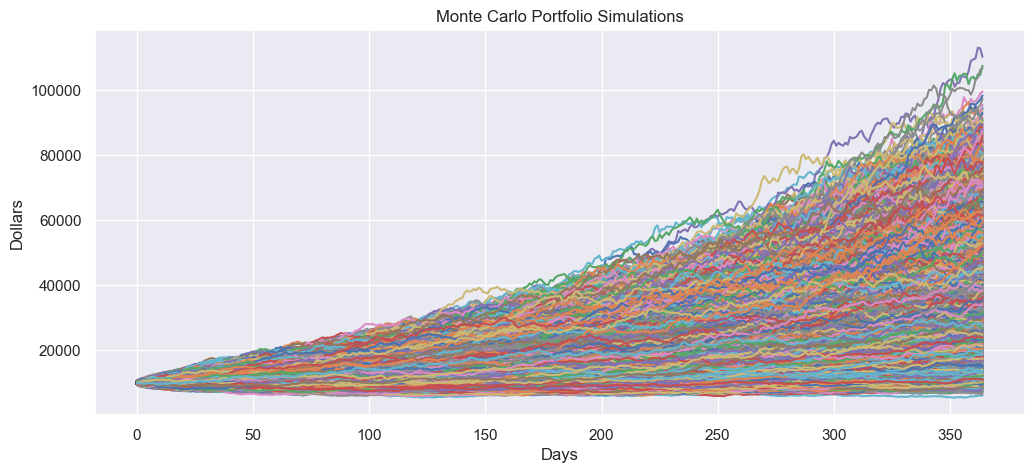

In [43]:
# Visualization of simulations
plt.figure(figsize=(12, 5))
plt.plot(portfolio_sims)
plt.title("Monte Carlo Portfolio Simulations")
plt.xlabel('Days')
plt.ylabel('Dollars');